In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.1 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install -qqq llava-torch==1.1.1 --progress-bar off

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.


In [2]:
import textwrap
from io import BytesIO

import requests
import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image

[2024-01-28 10:49:13,253] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
disable_torch_init()

In [4]:
MODEL = "4bit/llava-v1.5-13b-3GB"
model_name = get_model_name_from_path(MODEL)
model_name

'llava-v1.5-13b-3GB'

In [5]:
!gdown 1mp5rAo4-apdl0DJO5XXQhjMa2ja7IFEH
!gdown 1Qnutc8S7F6jMN6RkJZBgiAePymDcJ3Ii
!gdown 1XM7QgiuNj7KjapaEfjyfxMVWSdQaqsaH
!gdown 1m9v8EVZ16sYcUlCGUH8PFuLxFxaml90U
!gdown 1x7XtPRG-IbSxyCO-ZTo_P7jirwRFY-JN

Downloading...
From: https://drive.google.com/uc?id=1mp5rAo4-apdl0DJO5XXQhjMa2ja7IFEH
To: /content/btc-price-chart.png
100% 133k/133k [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qnutc8S7F6jMN6RkJZBgiAePymDcJ3Ii
To: /content/meme.jpeg
100% 109k/109k [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XM7QgiuNj7KjapaEfjyfxMVWSdQaqsaH
To: /content/captcha.jpeg
100% 4.52k/4.52k [00:00<00:00, 22.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1m9v8EVZ16sYcUlCGUH8PFuLxFxaml90U
To: /content/bitcoin-paper.jpg
100% 945k/945k [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x7XtPRG-IbSxyCO-ZTo_P7jirwRFY-JN
To: /content/bike-girl.jpeg
100% 207k/207k [00:00<00:00, 118MB/s]


In [6]:
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=MODEL, model_base=None, model_name=model_name, load_4bit=True
)

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

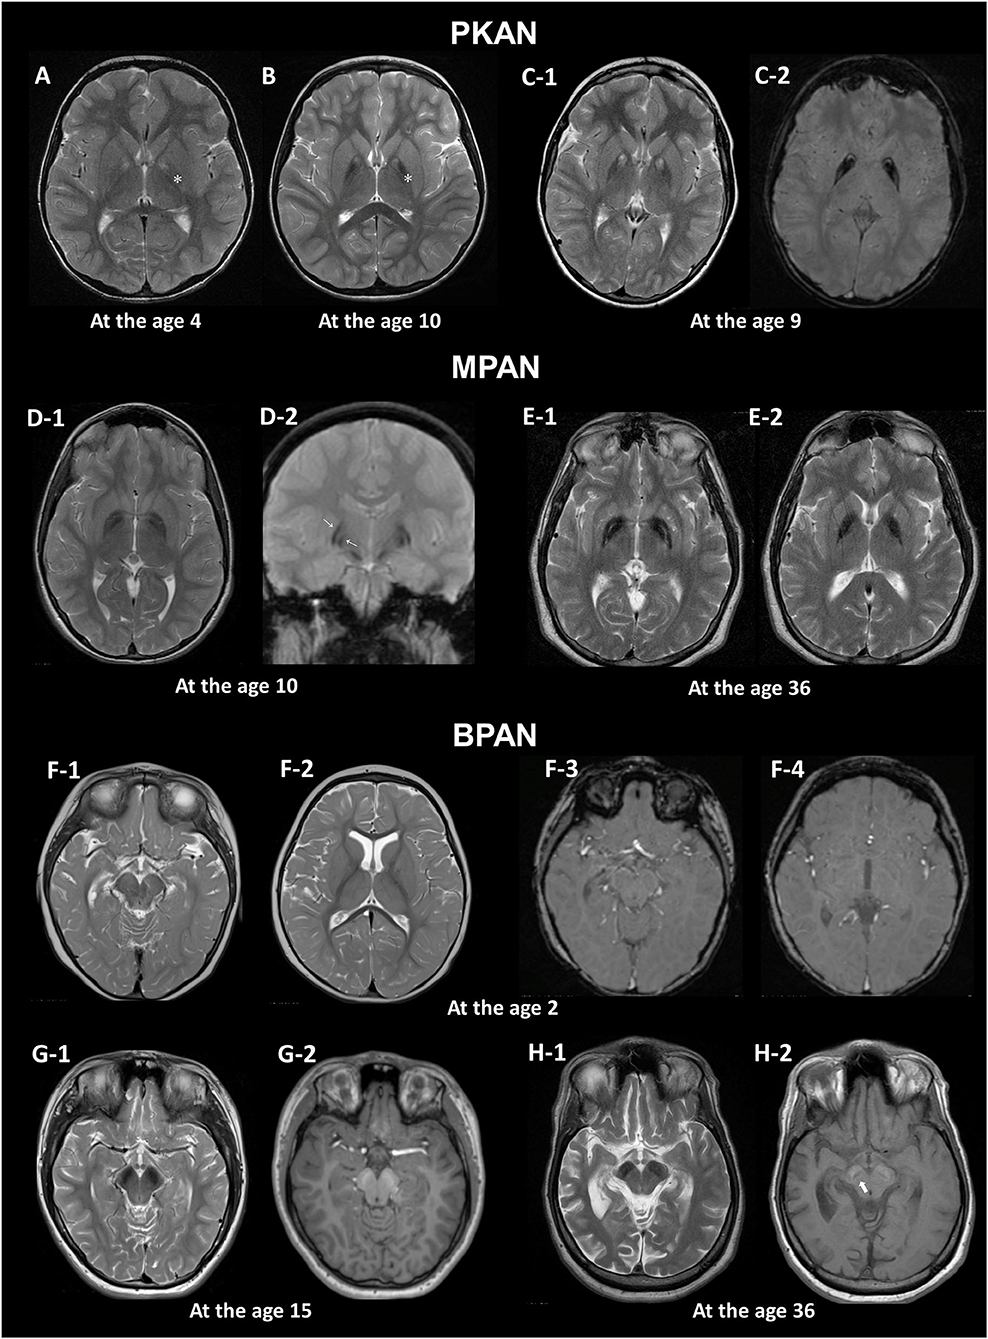

In [8]:
image = load_image("mri.jpeg")
image

In [9]:
def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

In [10]:
processed_image = process_image(image)
type(processed_image), processed_image.shape

(torch.Tensor, torch.Size([1, 3, 336, 336]))

In [11]:
CONV_MODE = "llava_v0"

In [12]:
def create_prompt(prompt: str):
    conv = conv_templates[CONV_MODE].copy()
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

In [13]:
prompt, _ = create_prompt("Describe the image")
print(prompt)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <image>
Describe the image###Assistant:


In [14]:
def ask_image(image: Image, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

In [15]:
%%time
result = ask_image(image, "Describe the image")
print(textwrap.fill(result, width=110))

The image is a black and white collage of various brain scans, showcasing different angles and perspectives of
the brain. There are ten different brain scans in total, each with distinct features and details. The scans
are arranged in a grid-like pattern, with some scans placed horizontally and others vertically. The image
provides a comprehensive view of the brain's structure and anatomy, highlighting the importance of brain
imaging in medical research and diagnosis.
CPU times: user 13.6 s, sys: 578 ms, total: 14.2 s
Wall time: 19.1 s


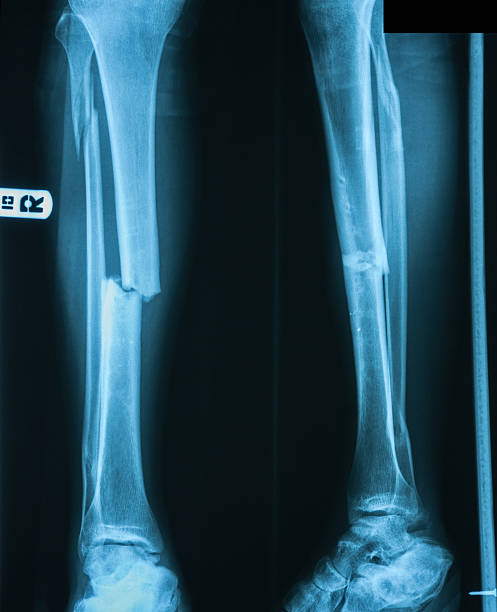

In [16]:
image = load_image("fracture.jpeg")
image

In [18]:
%%time
result = ask_image(image, "Describe the image and also comment on fracture region")
print(textwrap.fill(result, width=110))

The image features a pair of human legs, with one leg having a broken bone. The broken bone is visible in the
lower part of the leg, and the leg is in a cast to support the healing process. The other leg is also in a
cast, but it appears to be intact. The legs are positioned close to each other, and the broken leg is on the
left side. The scene suggests that the person has experienced a fracture, and the casts are being used to aid
in the recovery process.
CPU times: user 13.1 s, sys: 127 ms, total: 13.2 s
Wall time: 14.5 s


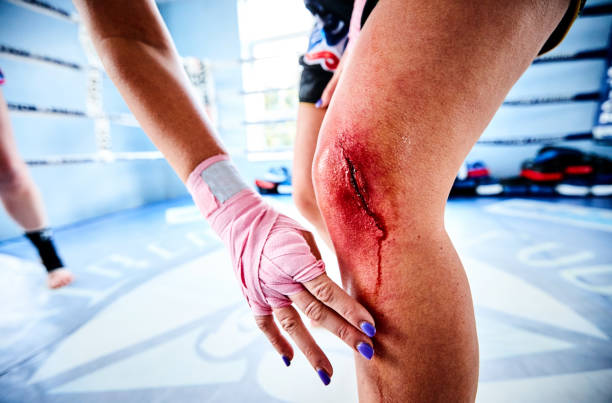

In [21]:
image = load_image("/leg.jpeg")
image

In [23]:
%%time
result = ask_image(image, "Describe the image and what can be done to heal this")
print(textwrap.fill(result, width=110))

The image shows a person with a red, bloody knee, possibly from a fight or an accident. The person is wearing
a pink glove and is holding their knee, which is covered in blood.  To heal this injury, it is essential to
clean the wound thoroughly and apply an antibiotic ointment to prevent infection. The person should also
consult a medical professional, such as a doctor or a nurse, to assess the severity of the injury and
determine the appropriate course of action. Depending on the severity of the injury, the person may require
medical treatment, such as stitches, a cast, or even surgery. Additionally, they should follow any recommended
rehabilitation or physical therapy to ensure a full recovery and prevent future injuries.
CPU times: user 18.9 s, sys: 406 ms, total: 19.3 s
Wall time: 19.6 s
